<a href="https://colab.research.google.com/github/minji-sung/minji-sung/blob/main/2_%E1%84%8B%E1%85%AA%E1%86%AB_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
% cd /content/drive/MyDrive/Colab Notebooks/bigcon/working directory

/content/drive/MyDrive/Colab Notebooks/bigcon/working directory2


In [ ]:
path = './'
filelist = [file for file in os.listdir(path) if file.endswith('.csv')]

database = {}
for file in filelist:
    database[file] = pd.read_csv(file)

In [ ]:
database = {key.replace('.csv', ''):val for key, val in database.items()}

In [ ]:
key_list=list(database.keys())
val_list=list(database.values())

In [ ]:
with open("./results/key_list.txt", "w") as output:
    output.write(str(key_list))


In [ ]:
df2 ={i : j.set_index('date') for i,j in database.items()}
df = pd.concat(df2, axis=0)

In [ ]:
df

price
       date                 
cala   2016-01-04   5.950497
       2016-01-11   5.252553
       2016-01-18   4.406059
       2016-01-25   6.489185
       2016-02-01   5.226887
...                      ...
salmon 2020-11-30  13.577170
       2020-12-07  12.933279
       2020-12-14  12.526810
       2020-12-21  11.882037
       2020-12-28  13.931000

[779 rows x 1 columns]

## adfuller 

In [ ]:
def dftest(dataframe):
    from statsmodels.tsa.stattools import adfuller
    timeseries = dataframe['price']
    test = adfuller(timeseries)
    dfoutput = pd.Series(test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput


In [ ]:
test = []

for i in key_list:
    output = dftest(df.loc[i, :])
    test.append(output)
print(test)

with open("./results/stationary_test_order_key_list.txt", "w") as output:
    output.write(str(test))


[Test Statistic                  -3.152220
p-value                          0.022922
#Lags Used                       6.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64, Test Statistic                  -2.283807
p-value                          0.177244
#Lags Used                       8.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64, Test Statistic                  -3.709484
p-value                          0.003982
#Lags Used                       2.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64]


### additional stationarisation

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print("Results of Dickey-Fuller Test:")
    array = np.asarray(timeseries, dtype='float')
    np.nan_to_num(array,copy=False)
    dftest = adfuller(array, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Dickey Fuller test p-value > 0.05 인 경우

In [ ]:
def log_stationary(dataframe):
    df_log = np.log(dataframe)
    rolling_mean = df_log.rolling(window=12).mean()
    df_log_minus_mean = df_log - rolling_mean
    df_log_minus_mean.dropna(inplace=True)
    df_log_minus_mean
    return test_stationarity(df_log_minus_mean['price'])

In [ ]:
def exp_decay_stationary(dataframe):
    df_log = np.log(dataframe)
    rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
    df_log_exp_decay = df_log - rolling_mean_exp_decay
    df_log_exp_decay.dropna(inplace=True)
    return test_stationarity(df_log_exp_decay['price'])

In [ ]:
def time_shifting_stationary(dataframe):
    df_log = np.log(dataframe)
    df_log_shift = df_log - df_log.shift()
    df_log_shift.dropna(inplace=True)
    return test_stationarity(df_log_shift['price'])

## ARIMA

In [ ]:
!pip install pmdarima
#Standard Imports
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

## SARIMA: 20% 테스트셋 & 검증력


In [ ]:
# 원래 있는 데이터들로 20퍼센트 테스트셋

from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

def arimamodel(timeseriesarray):
    stepwise_model = auto_arima(timeseriesarray, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

    train, test = train_test_split(timeseriesarray, test_size = 0.2, shuffle = False)
    results = stepwise_model.fit(train)
    
    future_forecast = stepwise_model.predict(n_periods= len(test))
    future_forecast1 = pd.DataFrame(future_forecast, index = test.index, columns=['Prediction'])
    
    path = './results/'
    dfname = [x for x in globals() if globals()[x] is timeseriesarray][0]
    future_forecast1.to_csv(f"{path}/기존구간_예측_" + str(dfname) + ".csv")

    future_forecast2 = pd.concat([timeseriesarray, future_forecast1],axis=1)
    pd.concat([timeseriesarray, future_forecast1],axis=1).plot(figsize=(12,8), title = f"result: ARIMA " + str(dfname))
    plt.savefig(f"{path}/기존구간_ARIMA_" + str(dfname) + ".png")

    return future_forecast
    

In [ ]:
% cd /content/drive/MyDrive/Colab Notebooks/bigcon

In [ ]:
df = pd.read_csv('./new_data0901.csv')
df = df[['date','cat2', 'name', 'price']]

df_shrimp = df[df.name == '흰다리새우']
df_salmon = df[df.cat2 == '연어']
df_cala = df[df.cat2 == '오징어']

df_salmon = df_salmon.groupby(by = 'date').mean() 
df_shrimp = df_shrimp.groupby(by = 'date').mean() 
df_cala = df_cala.groupby(by = 'date').mean() 

def cleaning(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe = dataframe[['date', 'price']]
    dataframe.index = dataframe['date']
    dataframe.set_index('date', inplace = True)
    return dataframe 

shrimp = cleaning(df_shrimp)
cala = cleaning(df_cala)
salmon = cleaning(df_salmon)


In [ ]:
forecast_salmon = arimamodel(df_salmon)
actual_salmon = np.array(df_salmon.iloc[208:].price)

forecast_shrimp = arimamodel(df_shrimp)
actual_shrimp = np.array(df_shrimp.iloc[208:].price)

forecast_cala = arimamodel(df_cala)
actual_cala = np.array(df_cala.iloc[207:].price)

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return ({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


In [ ]:
forecast_accuracy(forecast_salmon, actual_salmon)
forecast_accuracy(forecast_shrimp, actual_shrimp)
forecast_accuracy(forecast_cala, actual_cala)

## SARIMA: 미래기간 예측

In [ ]:
# 미래에 붙이기: start='20210101', end='20210630',freq='W-MON'

from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from datetime import datetime
from pandas_datareader import data
import json

def futurearimamodel(timeseriesarray):
    stepwise_model = auto_arima(timeseriesarray, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

    results = stepwise_model.fit(timeseriesarray)
    future_forecast_values = stepwise_model.predict(n_periods= 26)

    # adding future periods
    future_forecast = pd.DataFrame(future_forecast_values, columns = ['prediction'])
    dt_index = pd.date_range(start='20210101', end='20210630',freq='W-MON')
    dt_list = dt_index.strftime("%Y%m%d").tolist()
    future_forecast['date'] = pd.to_datetime(dt_list)
    future_forecast.index = future_forecast['date']
    future_forecast.set_index('date', inplace=True)
    #path = './results/'
    #dfname = [x for x in globals() if globals()[x] is timeseriesarray][0]
    #future_forecast.to_csv(f"{path}/미래_평가구간_예측_" + str(dfname) + ".csv")

    future = pd.concat([timeseriesarray, future_forecast],axis=0)
    #future.plot(figsize=(12,8), title = f"평가구간 ARIMA " + str(dfname))
    #plt.legend(['Price', 'Prediction'])
    #plt.savefig(f"{path}/평가구간_ARIMA_" + str(dfname) + ".png")

    # 강조 구간 (2021-01-04 ~ 2021-06-28)
    #span_start = datetime(2021, 1, 4)
    #span_end = datetime(2021, 6, 28)
    #plt.axvspan(span_start, span_end, facecolor='orange', alpha=0.5)

    #return print(stepwise_model.aic()), print(results.summary()), print(future_forecast_values), plt.show()
    return future       

In [ ]:
for i in key_list:
    output = futurearimamodel(df.loc[i, :])
    path = r"/content/drive/MyDrive/Colab Notebooks/bigcon/working directory2/results/future_" + i + "_arima.csv"
    output.to_csv(path, index=False)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1143.079, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=992.183, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1078.814, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=979.944, Time=0.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1048.026, Time=0.32 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=939.232, Time=0.56 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=951.965, Time=0.24 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.83 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=919.365, Time=0.60 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=936.833, Ti

In [ ]:
# 미래에 붙이기: start='20210101', end='20210630',freq='W-MON'

from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from datetime import datetime
from pandas_datareader import data
import json

def futurearimamodel_image(timeseriesarray):
    stepwise_model = auto_arima(timeseriesarray, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

    results = stepwise_model.fit(timeseriesarray)
    future_forecast_values = stepwise_model.predict(n_periods= 26)

    # adding future periods
    future_forecast = pd.DataFrame(future_forecast_values, columns = ['prediction'])
    dt_index = pd.date_range(start='20210101', end='20210630',freq='W-MON')
    dt_list = dt_index.strftime("%Y%m%d").tolist()
    future_forecast['date'] = pd.to_datetime(dt_list)
    future_forecast.index = future_forecast['date']
    future_forecast.set_index('date', inplace=True)
    future = pd.concat([timeseriesarray, future_forecast],axis=0)
    return future.plot(figsize=(12,8))       

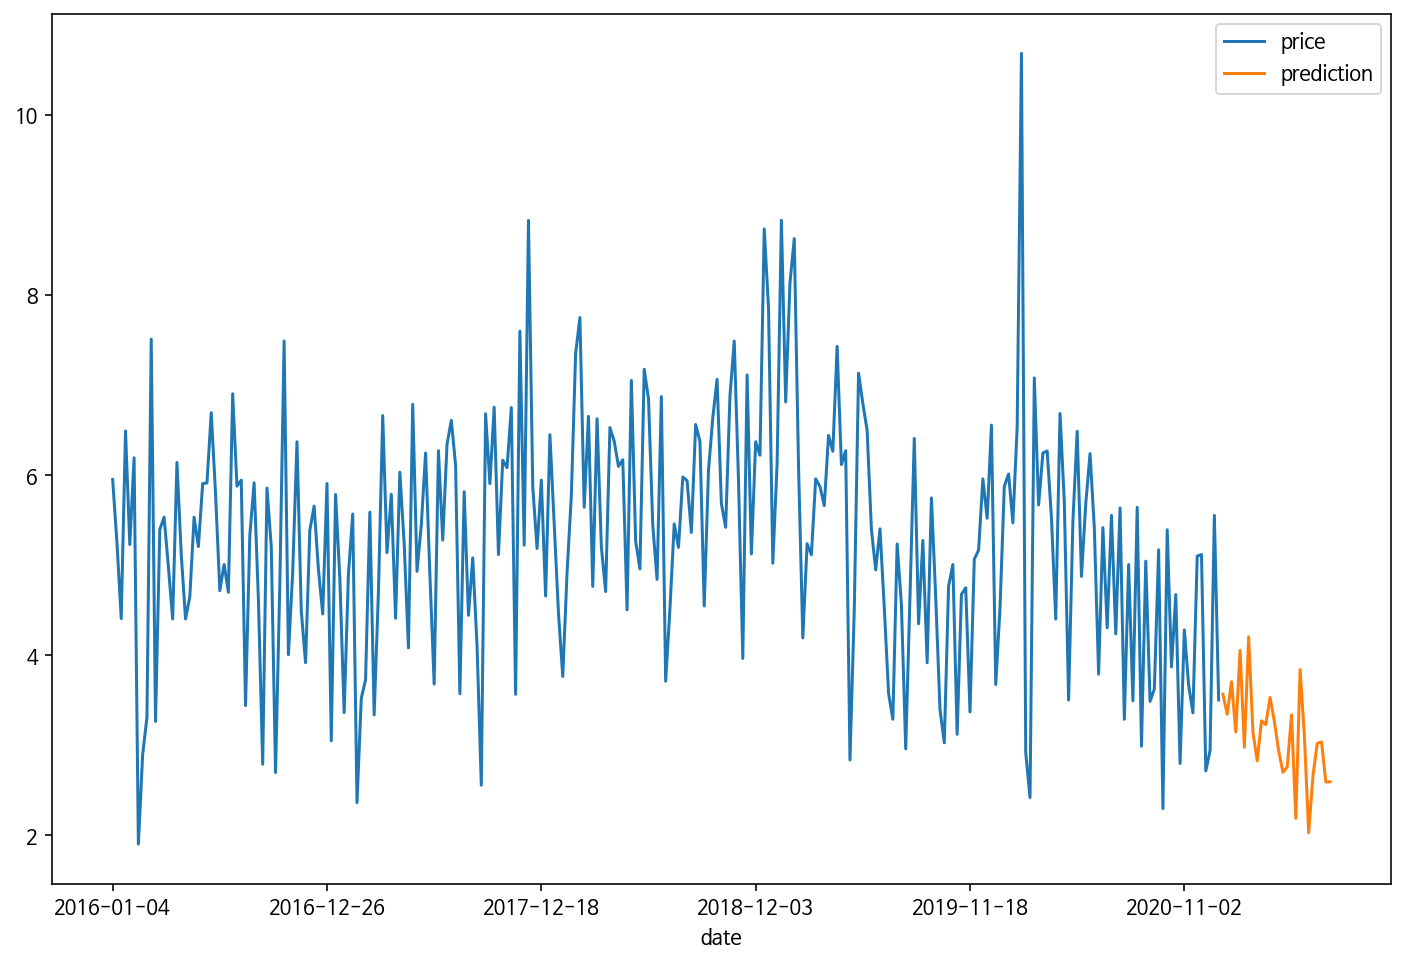

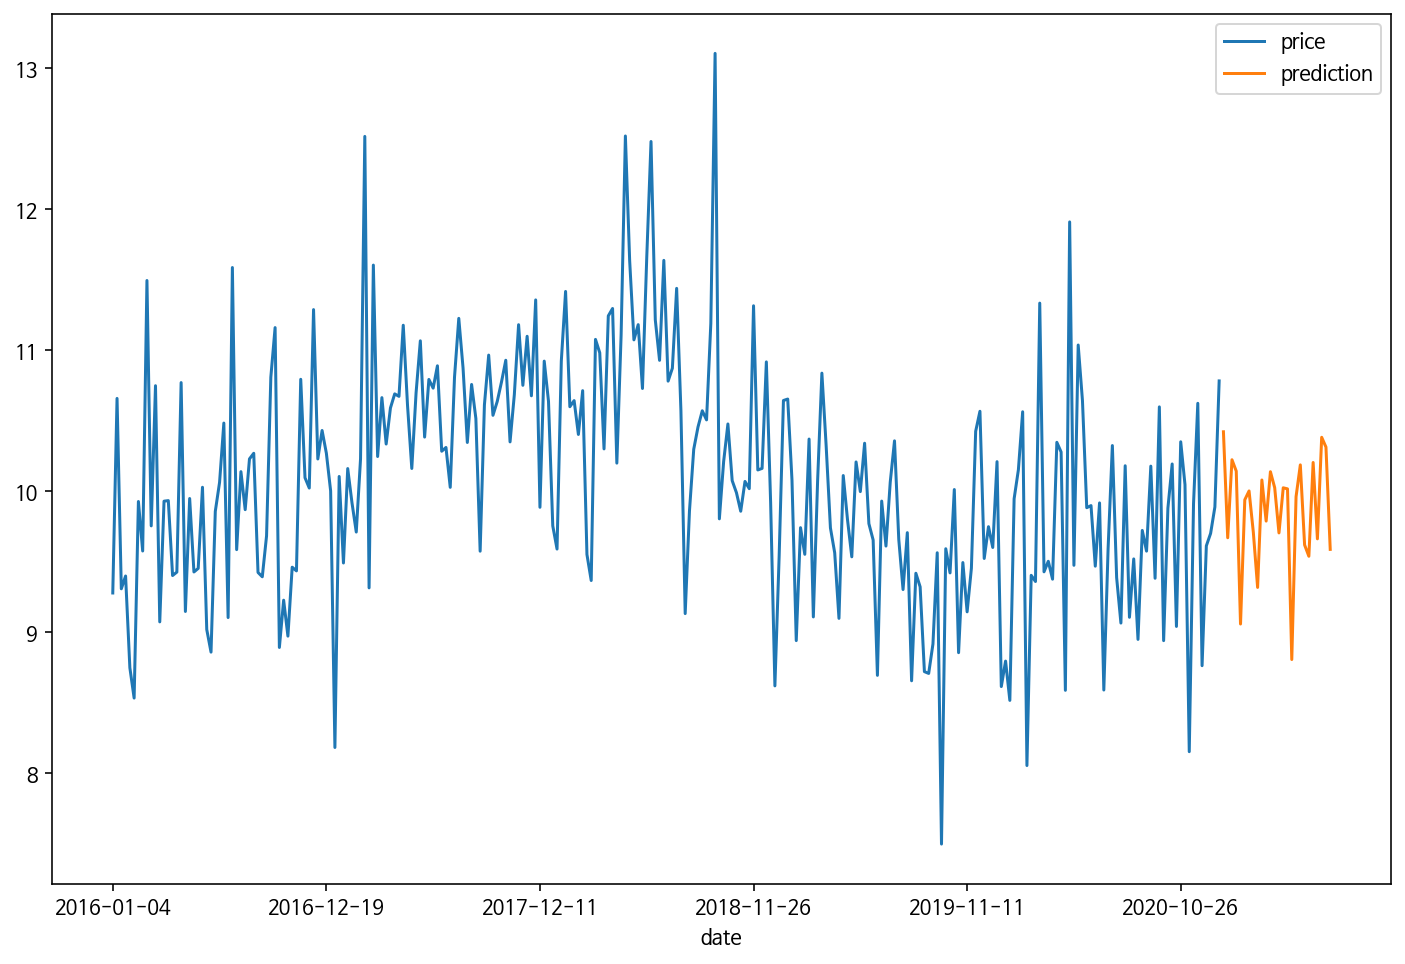

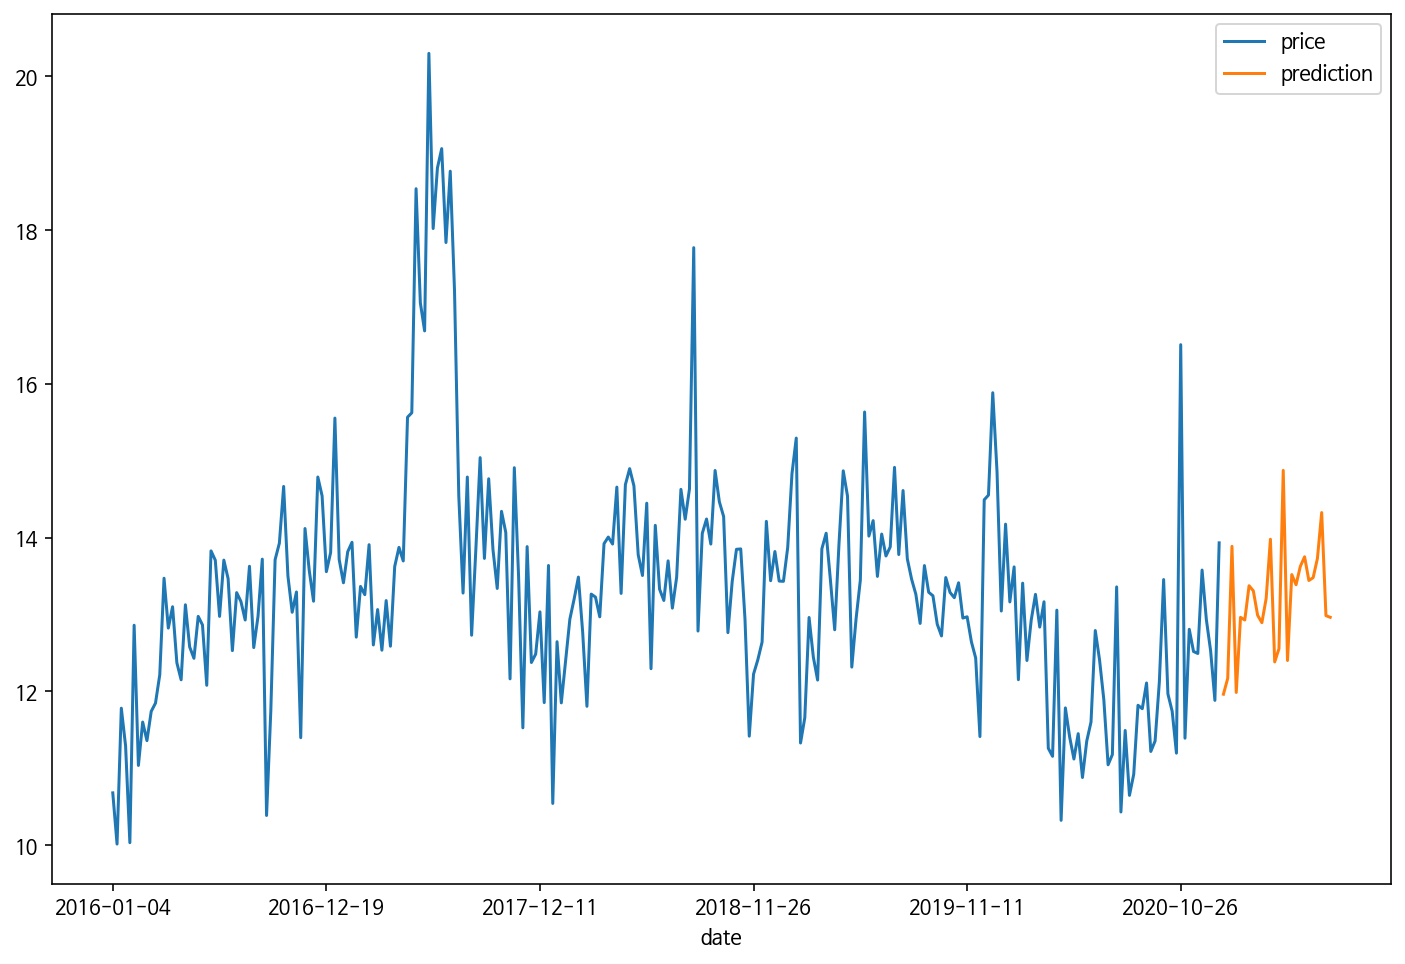

In [ ]:
for i in key_list:
    output = futurearimamodel_image(df.loc[i, :])
    path = r"/content/drive/MyDrive/Colab Notebooks/bigcon/working directory2/results/image_future_" + i + "_arima.png"
    output.figure.savefig(path)


In [ ]:
# 미래 모델 summary 저장

# 미래에 붙이기: start='20210101', end='20210630',freq='W-MON'

from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from datetime import datetime
from pandas_datareader import data
import json

def futurearimamodel_summary(timeseriesarray):
    stepwise_model = auto_arima(timeseriesarray, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

    results = stepwise_model.fit(timeseriesarray)
    future_forecast_values = stepwise_model.predict(n_periods= 26)

    # adding future periods
    future_forecast = pd.DataFrame(future_forecast_values, columns = ['prediction'])
    dt_index = pd.date_range(start='20210101', end='20210630',freq='W-MON')
    dt_list = dt_index.strftime("%Y%m%d").tolist()
    future_forecast['date'] = pd.to_datetime(dt_list)
    future_forecast.index = future_forecast['date']
    future_forecast.set_index('date', inplace=True)
    future = pd.concat([timeseriesarray, future_forecast],axis=0)
    return results.summary()

In [ ]:
for i in key_list:
    plt.rc('figure', figsize=(12, 7))
    plt.text(0.01, 0.05, str(futurearimamodel_summary(df.loc[i, :])), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off')
    plt.tight_layout()
    path = r"/content/drive/MyDrive/Colab Notebooks/bigcon/working directory2/results/summary_future_" + i + "_arima.png"
    plt.savefig(path)
    plt.close()